# Clase remota 1 del día 27/03/2020
<sup>Gabriel Missael Barco

No siempre el conjunto de parametros que mejor se ajusta a mis datos es el que es mas probable para mi modelo, es decir, el mejor ajuste podria tener parametros que son casi imposibles.
La respuesta a ambas preguntas (paramtreos con mejor ajuste o mas probables) muchas veces es la misma, pero esto no siempre es asi.

Para encontrar los valores mas probables, puedo tomar el conjunto de valores que mas se aproximan conjuntamente al minimo de manera recurrente en mi minimización. 

### Likelihood
Es una cosntrucción que realizamos para establecer la probabilidad de que nuestra hipotesis sobre un modelo o teoriea sea cierta dada que estamos observando unos datos determinados. Es la probabilidad de que el modelo sea el que describa a los datos.

No tiene una forma unica, depende del tipo de datos que estoy manejando, es decir, que tipo de distribución de probabilidad tienen estos. Por ejemplo, si los datos son gaussianos, entonces podemos pensar que el likelihood también es gaussiano. Tenemos, en general que:

$ L \propto \prod \limits_{i}^{n} \frac{1}{2\pi\sigma_i^2}exp(-\frac{(y_i-\mu)^2}{2\sigma_i^2})$

Por lo  general una minimización de chi-square corresponde a una maximización de el likelihood.Es importante notar que la preferencia entre minimizar chi-square o maximizar el likelihood (cuando estos no ocurren paraleleamente) depende completamente del problema que estemos abordando. No hay algo como uno mejor que otro.

Por ejemplo, en terminos de puntos de datos y paramatros (donde lambda es nuestro modelo para cada $y_i$) asumiendo que los datos tienen una **distribución gaussiana** de los datos, entonces el likilehood se puede obtener cómo:

$-ln(L(\vec x,\vec y|\vec\theta) \propto \frac{1}{2} \sum_i (\frac{(y_i-\lambda(x_i,\vec\theta))^2}{\sigma_i^2})$

Es util expresarlo de esta manera para eliminar el exponencial y tener datos mas 'digeribles'. Pero ¿que pasa si queremos maximizar el likelihood de muchos parametros para un modelo bastante complejo y si ademas no es gaussiano? Para ello nos sirve el metodo montecarlo.

### MonteCarlo - cadenas de Markov

Este metodo consiste en generar un muestreo aleatorio para los parametros (por ejemplo, en la ecuación anterior, las $\vec\theta$ son los parametros libres que podemos muestrear), y despues los rechaza o los acepta dependiendo del likelihood que estos datos tengan. Esta discriminación se hace de acuerdo a likelihood anteriores, y en general, el algoritmo es:

1. Elige un punto de partida $\vec p_{old}$.
2. Genera un punto nuevo en la vecindad de $\vec p_{old}$, dado una distribución gaussiana:
    - $p_{new}i = N(p_{old}i, \sigma_i)$
    
   Es importante notar que cada parametro puede     tener un sigma distinto
3. Si el likelihood de la nueva muestra es mas alta que la anterior, guardamos el nuevo:
    - si $L(\vec p_{new})>L(\vec p_{old})$ entonces:
    - $\vec L_{old} = L_{new}$
4. Si el likelihood de la nueva muestra es menor a la anterior, entonces tomamos un numero aleatorio $U = N(0,1)$; si el cociente de los likelihood $C = (p_{new})/(p_{old})$ es mas grande que dicho numero aleatorio, entonces la aceptamos.
5. Si no cumple ninguna de las dos, entonces lo rechazamos.
6. Regresa al paso 2, hasta dar N pasos.


Despues de haber realizado los N pasos, vemos la distribición resultante (las cadenas) de los parametros, y por lo tanto, su likelihood :).

Ojo: Checar el periodo de 'quemado' y la convergencia. 

<img src="https://www.researchgate.net/profile/Bernardita_Ried_Guachalla/publication/335291562/figure/fig2/AS:794195358924800@1566362337030/Example-of-a-Markov-Chain-Monte-Carlo-for-a-Multivariate-Gaussian-Distribution.ppm" alt="Drawing" style="width: 400px;"/>

Por lo general, teniendo un numero dado de parametros y despues de haber realizado el metodo montecarlo, los resulatados se suelen representar de la siguiente manera (muy util, y en 2d):

<img src="https://inspirehep.net/record/1720816/files/CMB+BAO+JLA_Al_usual_thesis.png" alt="Drawing" style="width: 400px;"/>

Esta representación nos ayuda para observar la dependencia o la 'interacción' entre los parametros en el resultado obtenido.

## Algoritmo en Python

A continuación, un algoritmo general de este metodo de montecarlo :)

In [343]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [344]:
def montecarlo_mc(datos, teoria, modelo, desviaciones, p_old, n_pasos=5000, step_size=1):
    '''
    REQUIREMENTS: Numpy
    DESCRIPTION: Esta funcion aplica el metodo de montecarlo para obtener los valores
                 mas probables de determinados parametros de un modelo aplicado a
                 ciertos datos conocidos.
    IN: datos = las x, variable independiente,
        teoria = las y, variable dependiente,
        modelo = funcion que aplica el modelo,
        desviaciones = desviaciones estandar conocidas para cada parametro,
        p_old = aproximación inicial,
        n_pasos = numero de pasos,
        step_size = tamaño maximo de avance en todos los parametros
    OUT: cadena de markov con likelihoods asociados
    '''
    
    markov_chain = []
    L_old = likelihood(datos, p_old, teoria, modelo, desviaciones)
    markov_chain.append([p_old, L_old])
    
    for paso in range(n_pasos):
        
        p_new = []
        for j, parametro in enumerate(p_old):
            p_new.append(desviaciones[j]*np.random.randn()*step_size+parametro)
        
        L_new = likelihood(datos, p_new, teoria, modelo, desviaciones)
        
        if (L_new>L_old):
            markov_chain.append([p_new, L_new])
            p_old = p_new
            L_old = L_new
            continue
        elif  (L_new/L_old > np.random.randn()):
            markov_chain.append([p_new, L_new])
        
    else:     
        return markov_chain
            
def likelihood(datos, parametros, teoria, modelo, desviaciones):
    return -(1/2)*np.sum((teoria-modelo(datos,parametros))**2)

### Ejemplo aplicado a recta
Usaremos este algoritmo para obtener los parametros de una recta, que son pendiente y ordenada al origen.

In [345]:
# Definimos el modelo que aplicamos, que es una recta
def recta(x, parametros):
    return x*parametros[0]+parametros[1]

#Construimos la recta:
x = np.linspace(0, 10, 1000)
#1.25, 3
p_reales = [10, 12]
des = [0.1, 0.1]
y = datos*P_reales[0]+P_reales[1]

#Aplicamos el mcmc
ajuste = montecarlo_mc(datos = x, teoria = y, modelo = recta, desviaciones = des,
                       p_old = [8, 8], n_pasos = 500, step_size = 1)

A continuacion, graficaremos los puntos obtenidos, es decir, las componentes de la cadena de markov resultante. Podemos ver como aparentemente 'avanza' hacia los valores conocidos de la pendiente y la ordenada al origen.

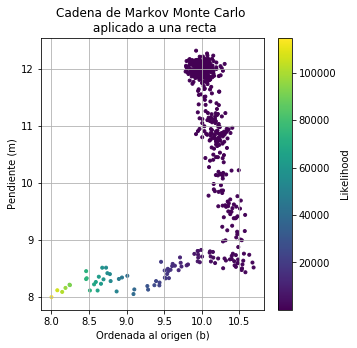

In [360]:
puntos = [x for x,y in ajuste]
like = [y for x, y in ajuste]

x = [x for x, y in puntos]
y = [y for x, y in puntos]

fig, ax0 = plt.subplots(figsize=(5, 5))

cadena = ax0.scatter(x, y, c = np.abs(like),  cmap = 'viridis', marker = '.')
ax0.plot()

ax0.set_ylabel('Pendiente (m)')
ax0.set_xlabel('Ordenada al origen (b)')
ax0.set_title('Cadena de Markov Monte Carlo \n aplicado a una recta') 

fig.colorbar(cadena, label='Likelihood')

ax0.grid()

In [351]:
print(f'La aproximación final es, para la pendiente m = {ajuste[-1][0][0]:.4f}\n' + \
        f'Para la ordenada al origen b = {ajuste[-1][0][1]:.4f}\n' +\
        f'Los datos reales eran b={p_reales[1]}, m = {p_reales[0]}')

La aproximación final es, para la pendiente m = 10.0341
Para la ordenada al origen b = 12.0646
Los datos reales eran b=12, m = 10
